In [1]:
#!pip install --upgrade --quiet statsmodels
from statsmodels .tsa.seasonal import seasonal_decompose

import numpy as np
import pandas as pd
import altair as alt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.mode.chained_assignment = None

%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 10)
mpl.rcParams.update({'font.size':22})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

print('Done')

Done


In [2]:
def getSmoothCurve(val, period=10):
    result = seasonal_decompose(val, model='additive', extrapolate_trend='freq',period=period)
    return result.trend

def get_mean_std(data, grp_cols, agg_col):
    df_mu = data.groupby(grp_cols)[agg_col].apply(lambda x: np.average(x)).reset_index()
    df_mu.columns = grp_cols + [f'Mean_{agg_col}']

    df_sigma = data.groupby(grp_cols)[agg_col].apply(lambda x: np.std(x)).reset_index()
    df_sigma.columns = grp_cols + [f'Std_{agg_col}']

    df_g = df_mu.merge(df_sigma, on=grp_cols)
    return df_g

In [3]:
data = pd.read_csv('../Data/Real_data_projected_v2.csv')
print(data.shape)
data.head()

(2291400, 6)


,P,Exp,W,M_GB,M_RF,M_XGB
0,1,1,0.0,0.000000,0.000000,0.000000
1,1,1,0.1,0.425324,0.425324,0.425324
2,1,1,0.2,0.854600,0.854600,0.854600
3,1,1,0.3,1.281640,1.281640,1.281640
4,1,1,0.4,1.700407,1.698880,1.704911


In [4]:
df_gb = get_mean_std(data, ['P','W'], 'M_GB')
print(df_gb.shape)
df_gb.head()

(1206, 4)


,P,W,Mean_M_GB,Std_M_GB
0,1,0.0,0.000000,0.000000
1,1,0.1,0.426748,0.000803
2,1,0.2,0.852910,0.001655
3,1,0.3,1.277499,0.002442
4,1,0.4,1.701078,0.000186


In [5]:
df_rf = get_mean_std(data, ['P','W'], 'M_RF')
print(df_rf.shape)
df_rf.head()

(1206, 4)


,P,W,Mean_M_RF,Std_M_RF
0,1,0.0,0.000000,0.000000
1,1,0.1,0.426748,0.000803
2,1,0.2,0.852910,0.001655
3,1,0.3,1.277499,0.002442
4,1,0.4,1.700463,0.000288


In [6]:
df_xgb = get_mean_std(data, ['P','W'], 'M_XGB')
print(df_xgb.shape)
df_xgb.head()

(1206, 4)


,P,W,Mean_M_XGB,Std_M_XGB
0,1,0.0,0.000000,0.000000
1,1,0.1,0.426748,0.000803
2,1,0.2,0.852910,0.001655
3,1,0.3,1.277499,0.002442
4,1,0.4,1.702742,0.000473


In [7]:
df = df_gb.merge(df_rf, on=['P','W'])
del[df_rf, df_gb]
print(df.shape)
df.head()

(1206, 6)


,P,W,Mean_M_GB,Std_M_GB,Mean_M_RF,Std_M_RF
0,1,0.0,0.000000,0.000000,0.000000,0.000000
1,1,0.1,0.426748,0.000803,0.426748,0.000803
2,1,0.2,0.852910,0.001655,0.852910,0.001655
3,1,0.3,1.277499,0.002442,1.277499,0.002442
4,1,0.4,1.701078,0.000186,1.700463,0.000288


In [8]:
df = df.merge(df_xgb, on=['P','W'])
del[df_xgb]
print(df.shape)
df.head()

(1206, 8)


,P,W,Mean_M_GB,Std_M_GB,Mean_M_RF,Std_M_RF,Mean_M_XGB,Std_M_XGB
0,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.1,0.426748,0.000803,0.426748,0.000803,0.426748,0.000803
2,1,0.2,0.852910,0.001655,0.852910,0.001655,0.852910,0.001655
3,1,0.3,1.277499,0.002442,1.277499,0.002442,1.277499,0.002442
4,1,0.4,1.701078,0.000186,1.700463,0.000288,1.702742,0.000473


## Compute $I(\omega)$

In [10]:
p1 = 2
p2 = 3
df_test = df[df.P.isin([p1,p2])]
td = []

for w in sorted(df_test.W.unique()):
    a = df_test.Mean_M_GB[df_test.W==w].values
    I_GB = ((p2*p2*a[1])-(p1*p1*a[0]))/((p2**2)-(p1**2))

    a = df_test.Mean_M_RF[df_test.W==w].values
    I_RF = ((p2*p2*a[1])-(p1*p1*a[0]))/((p2**2)-(p1**2))

    a = df_test.Mean_M_XGB[df_test.W==w].values
    I_XGB = ((p2*p2*a[1])-(p1*p1*a[0]))/((p2**2)-(p1**2))

    td.append([w, I_GB, I_RF, I_XGB])
    print(w, end=',')
        
print()
df_I = pd.DataFrame(td, columns=['W','I_GB','I_RF','I_XGB'])

df_I.loc[:,'smooth_IGB'] = 0.0
df_I.loc[:,'smooth_IRF'] = 0.0
df_I.loc[:,'smooth_IXGB'] = 0.0

df_I.sort_values(['W'], inplace=True, ascending=True)

vgb = df_I.I_GB[df_I.W>0]
vrf = df_I.I_RF[df_I.W>0]
vxgb = df_I.I_XGB[df_I.W>0]

df_I.smooth_IGB[df_I.W>0] = getSmoothCurve(vgb)
df_I.smooth_IRF[df_I.W>0] = getSmoothCurve(vrf)
df_I.smooth_IXGB[df_I.W>0] = getSmoothCurve(vxgb)

df_I.to_csv('../Data/Projected_I_no_exp.csv', index=False)
df_I.head()

0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4.0,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0,5.1,5.2,5.3,5.4,5.5,5.6,5.7,5.8,5.9,6.0,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7.0,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,7.9,8.0,8.1,8.2,8.3,8.4,8.5,8.6,8.7,8.8,8.9,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10.0,10.1,10.2,10.3,10.4,10.5,10.6,10.7,10.8,10.9,11.0,11.1,11.2,11.3,11.4,11.5,11.6,11.7,11.8,11.9,12.0,12.1,12.2,12.3,12.4,12.5,12.6,12.7,12.8,12.9,13.0,13.1,13.2,13.3,13.4,13.5,13.6,13.7,13.8,13.9,14.0,14.1,14.2,14.3,14.4,14.5,14.6,14.7,14.8,14.9,15.0,15.1,15.2,15.3,15.4,15.5,15.6,15.7,15.8,15.9,16.0,16.1,16.2,16.3,16.4,16.5,16.6,16.7,16.8,16.9,17.0,17.1,17.2,17.3,17.4,17.5,17.6,17.7,17.8,17.9,18.0,18.1,18.2,18.3,18.4,18.5,18.6,18.7,18.8,18.9,19.0,19.1,19.2,19.3,19.4,19.5,19.6,19.7,19.8,19.9,20.0,


,W,I_GB,I_RF,I_XGB,smooth_IGB,smooth_IRF,smooth_IXGB
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.1,0.003483,0.003483,0.003483,0.005089,0.004973,0.005067
2,0.2,0.006940,0.006940,0.006940,0.008291,0.008141,0.008233
3,0.3,0.010454,0.010454,0.010454,0.011494,0.011308,0.011399
4,0.4,0.013628,0.013852,0.013857,0.014697,0.014476,0.014565


# Plot

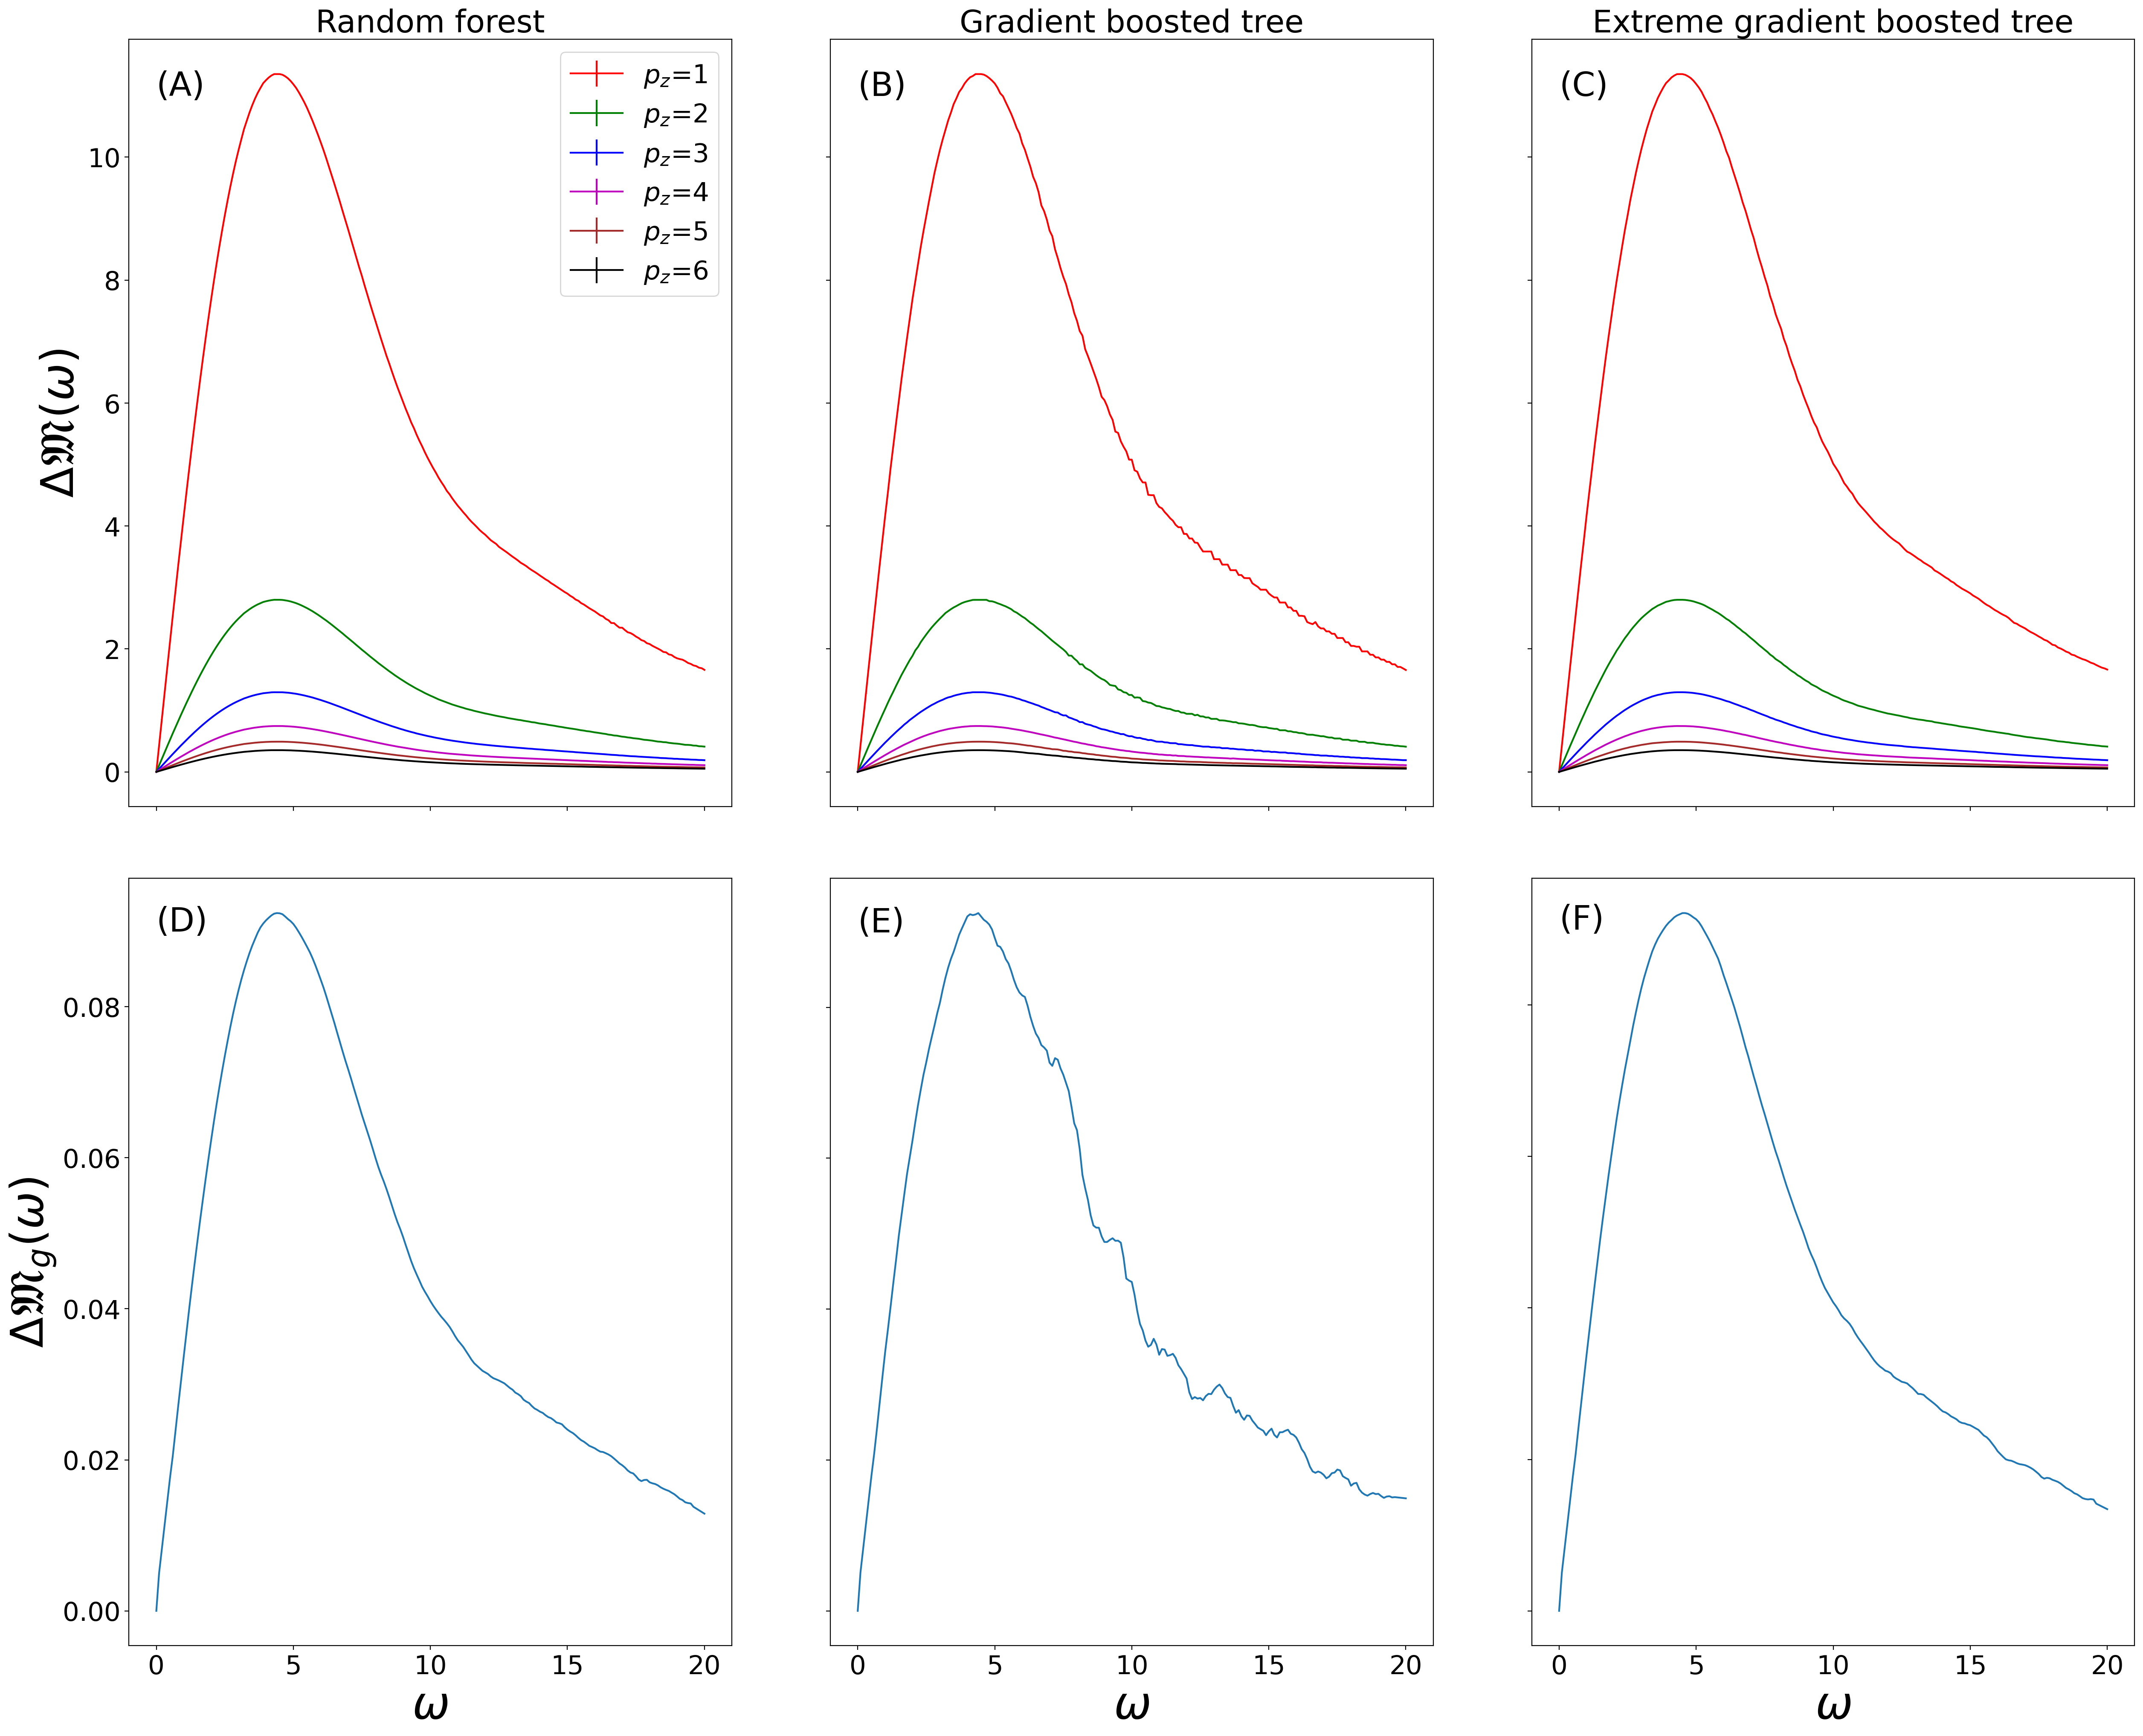

In [13]:
fig, ax = plt.subplots(2,3, figsize=(25,20), dpi=200)
fig.tight_layout()
colors = ['r','g','b','m','brown','black']
txt = np.array([["(A)","(B)","(C)"],["(D)","(E)","(F)"]])
c = 0

for i, mod in enumerate(['RF', 'GB', 'XGB']):
    f1 = f"Mean_M_{mod}"
    f2 = f"Std_M_{mod}"
    title = ''
    
    if mod=='GB':
        title = 'Gradient boosted tree'
    elif mod=='RF':
        title = 'Random forest'
    elif mod=='XGB':
        title = 'Extreme gradient boosted tree'
    
    r=0
    for p in range(1,7):

        t = df[df.P==p][['W',f1,f2]]
        if i==0:
            ax[r,c].errorbar(x=t.W, y=t[f1], yerr=t[f2], ecolor=colors[p-1], color=colors[p-1], label=f"$p_z$={p}", )
        else:
            ax[r,c].errorbar(x=t.W, y=t[f1], yerr=t[f2], ecolor=colors[p-1], color=colors[p-1])

        ax[r,c].set_title(title)
        ax[r,c].set_xticklabels([]) 
        
        if i==0:
            ax[r,c].set_ylabel('$\Delta\mathfrak{M}(\omega)$', fontsize=38)
            ax[r,c].legend()
        else:
            ax[r,c].set_yticklabels([]) 
            
    ax[r,c].text(x=0, y=11, s=f"{txt[r][c]}", fontsize=28)
    
    
    r=1
    ax[r,c].plot(df_I['W'], df_I[f"smooth_I{mod}"], '-')
    if i==0:
        ax[r,c].set_ylabel('$\Delta\mathfrak{M}_g(\omega)$', fontsize=38)
    else:
        ax[r,c].set_yticklabels([]) 
        
    ax[r,c].set_xlabel('$\omega$', fontsize=38)
    ax[r,c].text(x=0, y=0.09, s=f"{txt[r][c]}", fontsize=28)
    
    c+=1
    
plt.show()